# Preparação do Dataset

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A # Biblioteca pro para Augmentation
from albumentations.pytorch import ToTensorV2

# Mapeamento das classes
CLASS_MAP = {
    'DATASET_CARURU': 1,
    'DATASET_GRAMINEA_PORTE_ALTO': 2,
    'DATASET_GRAMINEA_PORTE_BAIXO': 3,
    'DATASET_MAMONA': 4,
    'DATASET_OUTRAS_FOLHAS_LARGAS': 5,
    'DATASET_TREPADEIRA': 6
}

class DaninhasDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        
        # Considerando a estrutura do dataset daninhas_multiclasse: .../NOME_CLASSE/rgb/imagem.jpg e .../NOME_CLASSE/labels/mascara.png
        path_parts = img_path.split(os.sep)
        
        # Encontrar nome da classe no caminho
        class_id = 0
        for part in path_parts:
            if part in CLASS_MAP:
                class_id = CLASS_MAP[part]
                break
        
        # Caminho da máscara (ajuste a extensão se for .jpg ou .png)
        mask_path = img_path.replace('rgb', 'labels').replace('.jpg', '.png')
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))
        
        # Converter máscara RGB para Máscara de Índices (0..6 e 255)
        mask_idx = np.full(mask_rgb.shape[:2], 255, dtype=np.uint8) # 255 = Ignorar (Branco)
        
        # Filtro para obter os pixels das classes
        is_black = np.all(mask_rgb < [30, 30, 30], axis=-1)   # Fundo analisado
        is_white = np.all(mask_rgb > [240, 240, 240], axis=-1) # Fundo não analisado
        is_weed  = (~is_black) & (~is_white)                   # Daninha
        
        mask_idx[is_black] = 0        # Classe 0 (Fundo)
        mask_idx[is_weed] = class_id  # Classe 1-6 (Daninha)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask_idx)
            image = augmented['image']
            mask_idx = augmented['mask']
            
        return image, mask_idx.long()

# Carregar arquivos
root_dir = "/media/guatambu/hdd/wesley/daninhas_multiclasse/"
all_files = sorted(glob.glob(os.path.join(root_dir, "*", "rgb", "*.jpg")))

train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(val_files, test_size=0.5, random_state=42)

/home/guatambu/Documentos/kanashiro/dinov3-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
len(train_files), len(val_files), len(test_files)

(8793, 1099, 1100)

## Funções para definir transformações

In [6]:
def get_basic_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# Transformações com Augmentations
def get_aug_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# Treinamento

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import JaccardIndex
from tqdm import tqdm 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
LR = 0.0001
EPOCHS = 50 
IGNORE_INDEX = 255

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

Using device: cuda


## Função para treinar os modelos

In [ ]:
def train_experiment(model, name, train_loader, val_loader, epochs):
    print(f"\nIniciando treinamento do modelo: {name}")
    
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    metric_iou = JaccardIndex(task="multiclass", num_classes=CLASSES, ignore_index=IGNORE_INDEX).to(DEVICE)
    
    history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        metric_iou.reset()
        
        loop = tqdm(train_loader, desc=f"Epoca {epoch+1}/{epochs} [{name}]", leave=False)
        
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            metric_iou.update(preds, masks)
            
            loop.set_postfix(loss=loss.item())
            
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = metric_iou.compute().item()
        
        # validação
        model.eval()
        val_loss = 0.0
        metric_iou.reset()
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                metric_iou.update(preds, masks)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = metric_iou.compute().item()
        
        # Armazena o histórico do treinamento
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_iou'].append(avg_train_iou)
        history['val_iou'].append(avg_val_iou)
        
        print(f"Ep {epoch+1}: Train IoU: {avg_train_iou:.4f} | Val IoU: {avg_val_iou:.4f}")
        
        # Checkpoint (salva o melhor peso)
        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            torch.save(model.state_dict(), f"best_model_{name}.pth")
            
    print(f"Fim do treino de {name}. Melhor IoU: {best_iou:.4f}")
    return history

## Carregando os modelos para o treinamento

In [8]:
import segmentation_models_pytorch as smp

# Parâmetros
ENCODER = 'resnet18' # Encoder pré-treinado (ResNet18) [Se der tempo, treinar com outro depois]
CLASSES = 7 # 0 (fundo) + 6 plantas

# U-Net
model_unet = smp.Unet(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# DeepLabV3+
model_deeplab = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# FPN (Feature Pyramid Network)
model_fpn = smp.FPN(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

# Modelos com Augmentations
model_unet_com_aug = smp.Unet(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)
model_deeplab_com_aug = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)
model_fpn_com_aug = smp.FPN(encoder_name=ENCODER, encoder_weights='imagenet', classes=CLASSES)

## Configuração dos datasets e dataloaders para treinamento

In [ ]:
train_dataset = DaninhasDataset(train_files, transform=get_basic_transform())
train_dataset_aug = DaninhasDataset(train_files, transform=get_aug_transform()) # usando augmentations
val_dataset   = DaninhasDataset(val_files, transform=get_basic_transform())
test_dataset  = DaninhasDataset(test_files, transform=get_basic_transform())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [157]:
# Dicionário com seus modelos instanciados
models_to_test = {
    "UNet": model_unet,
    "DeepLabV3+": model_deeplab,
    "FPN": model_fpn
}

# Dicionário com seus modelos instanciados com Augmentations
models_to_test_aug = {
    "UNet_com_Aug": model_unet_com_aug,
    "DeepLabV3+_com_Aug": model_deeplab_com_aug,
    "FPN_com_Aug": model_fpn_com_aug
}

results = {}

for model_name, model_instance in models_to_test.items():    
    hist = train_experiment(
        model=model_instance,
        name=model_name,
        train_loader=train_loader, 
        val_loader=val_loader,     
        epochs=EPOCHS
    )
    results[model_name] = hist

for model_name, model_instance in models_to_test_aug.items():    
    hist = train_experiment(
        model=model_instance,
        name=model_name,
        train_loader=train_loader_aug, 
        val_loader=val_loader,     
        epochs=EPOCHS
    )
    results[model_name] = hist


Iniciando treinamento do modelo: UNet


Epoca 1/50 [UNet]:   0%|          | 0/138 [00:00<?, ?it/s]

Ep 1: Train IoU: 0.1447 | Val IoU: 0.1926


Ep 2: Train IoU: 0.1902 | Val IoU: 0.1968


Ep 3: Train IoU: 0.2275 | Val IoU: 0.2112


Ep 4: Train IoU: 0.2485 | Val IoU: 0.2156


Ep 5: Train IoU: 0.2533 | Val IoU: 0.2356


Ep 6: Train IoU: 0.3003 | Val IoU: 0.2580


Ep 7: Train IoU: 0.3256 | Val IoU: 0.2447


Ep 8: Train IoU: 0.3459 | Val IoU: 0.2683


Ep 9: Train IoU: 0.3647 | Val IoU: 0.2344


Ep 10: Train IoU: 0.3826 | Val IoU: 0.3007


Ep 11: Train IoU: 0.3993 | Val IoU: 0.3314


Ep 12: Train IoU: 0.4035 | Val IoU: 0.2610


Ep 13: Train IoU: 0.4279 | Val IoU: 0.3264


Ep 14: Train IoU: 0.4872 | Val IoU: 0.3495


Ep 15: Train IoU: 0.5069 | Val IoU: 0.3862


Ep 16: Train IoU: 0.5164 | Val IoU: 0.3544


Ep 17: Train IoU: 0.5185 | Val IoU: 0.3891


Ep 18: Train IoU: 0.5292 | Val IoU: 0.4186


Ep 19: Train IoU: 0.5287 | Val IoU: 0.4021


Ep 20: Train IoU: 0.5344 | Val IoU: 0.3893


Ep 21: Train IoU: 0.5302 | Val IoU: 0.3862


Ep 22: Train IoU: 0.5309 | Val IoU: 0.3702


Ep 23: Train IoU: 0.5340 | Val IoU: 0.3352


Ep 24: Train IoU: 0.5321 | Val IoU: 0.3503


Ep 25: Train IoU: 0.5341 | Val IoU: 0.3815


Ep 26: Train IoU: 0.5316 | Val IoU: 0.3995


Ep 27: Train IoU: 0.5419 | Val IoU: 0.3743


Ep 28: Train IoU: 0.5454 | Val IoU: 0.4031


Ep 29: Train IoU: 0.5528 | Val IoU: 0.4090


Ep 30: Train IoU: 0.5554 | Val IoU: 0.3959


Ep 31: Train IoU: 0.5641 | Val IoU: 0.3917


Ep 32: Train IoU: 0.5604 | Val IoU: 0.3962


Ep 33: Train IoU: 0.5653 | Val IoU: 0.4026


Ep 34: Train IoU: 0.5591 | Val IoU: 0.4054


Ep 35: Train IoU: 0.5665 | Val IoU: 0.4019


Ep 36: Train IoU: 0.5658 | Val IoU: 0.3725


Ep 37: Train IoU: 0.5431 | Val IoU: 0.3021


Ep 38: Train IoU: 0.4960 | Val IoU: 0.2993


Ep 39: Train IoU: 0.4970 | Val IoU: 0.3846


Ep 40: Train IoU: 0.5482 | Val IoU: 0.4024


Ep 41: Train IoU: 0.5565 | Val IoU: 0.4138


Ep 42: Train IoU: 0.5631 | Val IoU: 0.4031


Ep 43: Train IoU: 0.5648 | Val IoU: 0.3850


Ep 44: Train IoU: 0.5683 | Val IoU: 0.4025


Ep 45: Train IoU: 0.5699 | Val IoU: 0.4009


Ep 46: Train IoU: 0.5798 | Val IoU: 0.4175


Ep 47: Train IoU: 0.5712 | Val IoU: 0.3981


Ep 48: Train IoU: 0.5730 | Val IoU: 0.4121


Ep 49: Train IoU: 0.5779 | Val IoU: 0.4095


Ep 50: Train IoU: 0.5749 | Val IoU: 0.4129
Fim do treino de UNet. Melhor IoU: 0.4186

Iniciando treinamento do modelo: DeepLabV3+


Ep 1: Train IoU: 0.1382 | Val IoU: 0.1986


Ep 2: Train IoU: 0.2484 | Val IoU: 0.2253


Ep 3: Train IoU: 0.2896 | Val IoU: 0.2709


Ep 4: Train IoU: 0.3207 | Val IoU: 0.3032


Ep 5: Train IoU: 0.3666 | Val IoU: 0.2970


Ep 6: Train IoU: 0.4165 | Val IoU: 0.3615


Ep 7: Train IoU: 0.4339 | Val IoU: 0.3511


Ep 8: Train IoU: 0.4661 | Val IoU: 0.3677


Ep 9: Train IoU: 0.4753 | Val IoU: 0.3461


Ep 10: Train IoU: 0.4876 | Val IoU: 0.3793


Ep 11: Train IoU: 0.5033 | Val IoU: 0.3838


Ep 12: Train IoU: 0.5095 | Val IoU: 0.3764


Ep 13: Train IoU: 0.5158 | Val IoU: 0.3329


Ep 14: Train IoU: 0.5209 | Val IoU: 0.3706


Ep 15: Train IoU: 0.5131 | Val IoU: 0.3823


Ep 16: Train IoU: 0.5177 | Val IoU: 0.3803


Ep 17: Train IoU: 0.5315 | Val IoU: 0.3829


Ep 18: Train IoU: 0.5384 | Val IoU: 0.3775


Ep 19: Train IoU: 0.5409 | Val IoU: 0.3891


Ep 20: Train IoU: 0.5469 | Val IoU: 0.3676


Ep 21: Train IoU: 0.5467 | Val IoU: 0.3751


Ep 22: Train IoU: 0.5342 | Val IoU: 0.4155


Ep 23: Train IoU: 0.5432 | Val IoU: 0.3669


Ep 24: Train IoU: 0.5391 | Val IoU: 0.3764


Ep 25: Train IoU: 0.5503 | Val IoU: 0.4098


Ep 26: Train IoU: 0.5578 | Val IoU: 0.4017


Ep 27: Train IoU: 0.5642 | Val IoU: 0.3892


Ep 28: Train IoU: 0.5589 | Val IoU: 0.4072


Ep 29: Train IoU: 0.5590 | Val IoU: 0.3836


Ep 30: Train IoU: 0.5594 | Val IoU: 0.3941


Ep 31: Train IoU: 0.5419 | Val IoU: 0.3921


Ep 32: Train IoU: 0.5480 | Val IoU: 0.3969


Ep 33: Train IoU: 0.5570 | Val IoU: 0.3742


Ep 34: Train IoU: 0.5683 | Val IoU: 0.4014


Ep 35: Train IoU: 0.5607 | Val IoU: 0.4018


Ep 36: Train IoU: 0.5633 | Val IoU: 0.4055


Ep 37: Train IoU: 0.5465 | Val IoU: 0.3225


Ep 38: Train IoU: 0.4805 | Val IoU: 0.4030


Ep 39: Train IoU: 0.5386 | Val IoU: 0.4106


Ep 40: Train IoU: 0.5583 | Val IoU: 0.4185


Ep 41: Train IoU: 0.5655 | Val IoU: 0.4151


Ep 42: Train IoU: 0.5702 | Val IoU: 0.4087


Ep 43: Train IoU: 0.5694 | Val IoU: 0.4110


Ep 44: Train IoU: 0.5716 | Val IoU: 0.4092


Ep 45: Train IoU: 0.5713 | Val IoU: 0.4123


Ep 46: Train IoU: 0.5790 | Val IoU: 0.4075


Ep 47: Train IoU: 0.5678 | Val IoU: 0.4113


Ep 48: Train IoU: 0.5699 | Val IoU: 0.4112


Ep 49: Train IoU: 0.5756 | Val IoU: 0.4166


Ep 50: Train IoU: 0.5725 | Val IoU: 0.4121
Fim do treino de DeepLabV3+. Melhor IoU: 0.4185

Iniciando treinamento do modelo: FPN


Ep 1: Train IoU: 0.1842 | Val IoU: 0.2133


Ep 2: Train IoU: 0.2918 | Val IoU: 0.2836


Ep 3: Train IoU: 0.3393 | Val IoU: 0.2743


Ep 4: Train IoU: 0.3790 | Val IoU: 0.3356


Ep 5: Train IoU: 0.4168 | Val IoU: 0.3198


Ep 6: Train IoU: 0.4423 | Val IoU: 0.3181


Ep 7: Train IoU: 0.4629 | Val IoU: 0.3862


Ep 8: Train IoU: 0.4797 | Val IoU: 0.3620


Ep 9: Train IoU: 0.4841 | Val IoU: 0.3849


Ep 10: Train IoU: 0.4918 | Val IoU: 0.3893


Ep 11: Train IoU: 0.5005 | Val IoU: 0.3871


Ep 12: Train IoU: 0.5143 | Val IoU: 0.3973


Ep 13: Train IoU: 0.5139 | Val IoU: 0.4072


Ep 14: Train IoU: 0.5216 | Val IoU: 0.3776


Ep 15: Train IoU: 0.5194 | Val IoU: 0.3941


Ep 16: Train IoU: 0.5295 | Val IoU: 0.3816


Ep 17: Train IoU: 0.5126 | Val IoU: 0.4049


Ep 18: Train IoU: 0.5335 | Val IoU: 0.3968


Ep 19: Train IoU: 0.5376 | Val IoU: 0.3819


Ep 20: Train IoU: 0.5421 | Val IoU: 0.3705


Ep 21: Train IoU: 0.5447 | Val IoU: 0.4063


Ep 22: Train IoU: 0.5459 | Val IoU: 0.4088


Ep 23: Train IoU: 0.5536 | Val IoU: 0.3987


Ep 24: Train IoU: 0.5484 | Val IoU: 0.4033


Ep 25: Train IoU: 0.5119 | Val IoU: 0.3687


Ep 26: Train IoU: 0.5222 | Val IoU: 0.3907


Ep 27: Train IoU: 0.5378 | Val IoU: 0.3763


Ep 28: Train IoU: 0.5557 | Val IoU: 0.4015


Ep 29: Train IoU: 0.5560 | Val IoU: 0.4203


Ep 30: Train IoU: 0.5598 | Val IoU: 0.4121


Ep 31: Train IoU: 0.5590 | Val IoU: 0.4132


Ep 32: Train IoU: 0.5628 | Val IoU: 0.4071


Ep 33: Train IoU: 0.5654 | Val IoU: 0.4070


Ep 34: Train IoU: 0.5685 | Val IoU: 0.4170


Ep 35: Train IoU: 0.5606 | Val IoU: 0.4083


Ep 36: Train IoU: 0.5710 | Val IoU: 0.4115


Ep 37: Train IoU: 0.5705 | Val IoU: 0.4109


Ep 38: Train IoU: 0.5692 | Val IoU: 0.4078


Ep 39: Train IoU: 0.5620 | Val IoU: 0.3842


Ep 40: Train IoU: 0.5655 | Val IoU: 0.4077


Ep 41: Train IoU: 0.5645 | Val IoU: 0.4262


Ep 42: Train IoU: 0.5746 | Val IoU: 0.4019


Ep 43: Train IoU: 0.5722 | Val IoU: 0.3954


Ep 44: Train IoU: 0.5726 | Val IoU: 0.4155


Ep 45: Train IoU: 0.5674 | Val IoU: 0.4149


Ep 46: Train IoU: 0.5519 | Val IoU: 0.3236


Ep 47: Train IoU: 0.4575 | Val IoU: 0.3691


Ep 48: Train IoU: 0.5325 | Val IoU: 0.4182


Ep 49: Train IoU: 0.5494 | Val IoU: 0.4088


Ep 50: Train IoU: 0.5576 | Val IoU: 0.4078
Fim do treino de FPN. Melhor IoU: 0.4262

Iniciando treinamento do modelo: UNet_com_Aug


Ep 1: Train IoU: 0.1429 | Val IoU: 0.2070


Ep 2: Train IoU: 0.1922 | Val IoU: 0.1847


Ep 3: Train IoU: 0.1911 | Val IoU: 0.2019


Ep 4: Train IoU: 0.2017 | Val IoU: 0.2237


Ep 5: Train IoU: 0.2238 | Val IoU: 0.2426


Ep 6: Train IoU: 0.2593 | Val IoU: 0.2330


Ep 7: Train IoU: 0.2714 | Val IoU: 0.2569


Ep 8: Train IoU: 0.2805 | Val IoU: 0.3000


Ep 9: Train IoU: 0.2937 | Val IoU: 0.3103


Ep 10: Train IoU: 0.3161 | Val IoU: 0.3348


Ep 11: Train IoU: 0.3229 | Val IoU: 0.3090


Ep 12: Train IoU: 0.3531 | Val IoU: 0.3518


Ep 13: Train IoU: 0.3574 | Val IoU: 0.3053


Ep 14: Train IoU: 0.3885 | Val IoU: 0.3410


Ep 15: Train IoU: 0.4073 | Val IoU: 0.4020


Ep 16: Train IoU: 0.4261 | Val IoU: 0.4176


Ep 17: Train IoU: 0.4270 | Val IoU: 0.3663


Ep 18: Train IoU: 0.4475 | Val IoU: 0.3734


Ep 19: Train IoU: 0.4466 | Val IoU: 0.3675


Ep 20: Train IoU: 0.4472 | Val IoU: 0.4282


Ep 21: Train IoU: 0.4217 | Val IoU: 0.3787


Ep 22: Train IoU: 0.4477 | Val IoU: 0.4164


Ep 23: Train IoU: 0.4558 | Val IoU: 0.4107


Ep 24: Train IoU: 0.4462 | Val IoU: 0.4128


Ep 25: Train IoU: 0.4537 | Val IoU: 0.4220


Ep 26: Train IoU: 0.4738 | Val IoU: 0.3993


Ep 27: Train IoU: 0.4672 | Val IoU: 0.4353


Ep 28: Train IoU: 0.4819 | Val IoU: 0.4212


Ep 29: Train IoU: 0.4807 | Val IoU: 0.4294


Ep 30: Train IoU: 0.4789 | Val IoU: 0.3947


Ep 31: Train IoU: 0.4764 | Val IoU: 0.4337


Ep 32: Train IoU: 0.4809 | Val IoU: 0.4181


Ep 33: Train IoU: 0.4865 | Val IoU: 0.3867


Ep 34: Train IoU: 0.4973 | Val IoU: 0.4221


Ep 35: Train IoU: 0.4727 | Val IoU: 0.4468


Ep 36: Train IoU: 0.4806 | Val IoU: 0.4384


Ep 37: Train IoU: 0.4840 | Val IoU: 0.4301


Ep 38: Train IoU: 0.4873 | Val IoU: 0.4412


Ep 39: Train IoU: 0.4910 | Val IoU: 0.4299


Ep 40: Train IoU: 0.4866 | Val IoU: 0.4401


Ep 41: Train IoU: 0.4897 | Val IoU: 0.4382


Ep 42: Train IoU: 0.5031 | Val IoU: 0.4441


Ep 43: Train IoU: 0.5008 | Val IoU: 0.4261


Ep 44: Train IoU: 0.4941 | Val IoU: 0.4204


Ep 45: Train IoU: 0.5006 | Val IoU: 0.3959


Ep 46: Train IoU: 0.4978 | Val IoU: 0.3919


Ep 47: Train IoU: 0.4957 | Val IoU: 0.4250


Ep 48: Train IoU: 0.5024 | Val IoU: 0.3964


Ep 49: Train IoU: 0.5051 | Val IoU: 0.4477


Ep 50: Train IoU: 0.4916 | Val IoU: 0.4362
Fim do treino de UNet_com_Aug. Melhor IoU: 0.4477

Iniciando treinamento do modelo: DeepLabV3+_com_Aug


Ep 1: Train IoU: 0.1694 | Val IoU: 0.2087


Ep 2: Train IoU: 0.2364 | Val IoU: 0.2461


Ep 3: Train IoU: 0.2624 | Val IoU: 0.2504


Ep 4: Train IoU: 0.2714 | Val IoU: 0.2841


Ep 5: Train IoU: 0.2943 | Val IoU: 0.2673


Ep 6: Train IoU: 0.3198 | Val IoU: 0.3296


Ep 7: Train IoU: 0.3277 | Val IoU: 0.3631


Ep 8: Train IoU: 0.3573 | Val IoU: 0.3382


Ep 9: Train IoU: 0.3904 | Val IoU: 0.3485


Ep 10: Train IoU: 0.4013 | Val IoU: 0.3973


Ep 11: Train IoU: 0.4218 | Val IoU: 0.3631


Ep 12: Train IoU: 0.4079 | Val IoU: 0.3796


Ep 13: Train IoU: 0.4332 | Val IoU: 0.4046


Ep 14: Train IoU: 0.4363 | Val IoU: 0.4017


Ep 15: Train IoU: 0.4494 | Val IoU: 0.4036


Ep 16: Train IoU: 0.4364 | Val IoU: 0.3936


Ep 17: Train IoU: 0.4491 | Val IoU: 0.4171


Ep 18: Train IoU: 0.4615 | Val IoU: 0.3238


Ep 19: Train IoU: 0.4355 | Val IoU: 0.4324


Ep 20: Train IoU: 0.4718 | Val IoU: 0.4389


Ep 21: Train IoU: 0.4700 | Val IoU: 0.4369


Ep 22: Train IoU: 0.4754 | Val IoU: 0.3998


Ep 23: Train IoU: 0.4752 | Val IoU: 0.4427


Ep 24: Train IoU: 0.4845 | Val IoU: 0.4329


Ep 25: Train IoU: 0.4818 | Val IoU: 0.4228


Ep 26: Train IoU: 0.4878 | Val IoU: 0.4418


Ep 27: Train IoU: 0.4744 | Val IoU: 0.4464


Ep 28: Train IoU: 0.4885 | Val IoU: 0.4252


Ep 29: Train IoU: 0.4983 | Val IoU: 0.4220


Ep 30: Train IoU: 0.4941 | Val IoU: 0.4240


Ep 31: Train IoU: 0.4880 | Val IoU: 0.4495


Ep 32: Train IoU: 0.4969 | Val IoU: 0.3953


Ep 33: Train IoU: 0.4894 | Val IoU: 0.4362


Ep 34: Train IoU: 0.5000 | Val IoU: 0.4289


Ep 35: Train IoU: 0.4966 | Val IoU: 0.4215


Ep 36: Train IoU: 0.4665 | Val IoU: 0.4124


Ep 37: Train IoU: 0.4990 | Val IoU: 0.3949


Ep 38: Train IoU: 0.4934 | Val IoU: 0.4361


Ep 39: Train IoU: 0.5011 | Val IoU: 0.4458


Ep 40: Train IoU: 0.5031 | Val IoU: 0.3938


Ep 41: Train IoU: 0.4952 | Val IoU: 0.4314


Ep 42: Train IoU: 0.5063 | Val IoU: 0.4333


Ep 43: Train IoU: 0.4968 | Val IoU: 0.4281


Ep 44: Train IoU: 0.5117 | Val IoU: 0.4323


Ep 45: Train IoU: 0.5121 | Val IoU: 0.4300


Ep 46: Train IoU: 0.5126 | Val IoU: 0.4461


Ep 47: Train IoU: 0.5074 | Val IoU: 0.4290


Ep 48: Train IoU: 0.5206 | Val IoU: 0.4632


Ep 49: Train IoU: 0.5019 | Val IoU: 0.4337


Ep 50: Train IoU: 0.4737 | Val IoU: 0.4185
Fim do treino de DeepLabV3+_com_Aug. Melhor IoU: 0.4632

Iniciando treinamento do modelo: FPN_com_Aug


Ep 1: Train IoU: 0.2057 | Val IoU: 0.2442


Ep 2: Train IoU: 0.2727 | Val IoU: 0.2890


Ep 3: Train IoU: 0.3119 | Val IoU: 0.3056


Ep 4: Train IoU: 0.3342 | Val IoU: 0.3016


Ep 5: Train IoU: 0.3479 | Val IoU: 0.2801


Ep 6: Train IoU: 0.3637 | Val IoU: 0.3546


Ep 7: Train IoU: 0.3829 | Val IoU: 0.3174


Ep 8: Train IoU: 0.4021 | Val IoU: 0.3661


Ep 9: Train IoU: 0.4133 | Val IoU: 0.3869


Ep 10: Train IoU: 0.4005 | Val IoU: 0.3978


Ep 11: Train IoU: 0.4227 | Val IoU: 0.3020


Ep 12: Train IoU: 0.4282 | Val IoU: 0.3646


Ep 13: Train IoU: 0.4403 | Val IoU: 0.4169


Ep 14: Train IoU: 0.4379 | Val IoU: 0.3950


Ep 15: Train IoU: 0.4383 | Val IoU: 0.3848


Ep 16: Train IoU: 0.4537 | Val IoU: 0.4195


Ep 17: Train IoU: 0.4584 | Val IoU: 0.4147


Ep 18: Train IoU: 0.4613 | Val IoU: 0.4141


Ep 19: Train IoU: 0.4636 | Val IoU: 0.4156


Ep 20: Train IoU: 0.4665 | Val IoU: 0.4131


Ep 21: Train IoU: 0.4714 | Val IoU: 0.4061


Ep 22: Train IoU: 0.4777 | Val IoU: 0.4006


Ep 23: Train IoU: 0.4483 | Val IoU: 0.4081


Ep 24: Train IoU: 0.4612 | Val IoU: 0.3663


Ep 25: Train IoU: 0.4807 | Val IoU: 0.4314


Ep 26: Train IoU: 0.4787 | Val IoU: 0.4363


Ep 27: Train IoU: 0.4897 | Val IoU: 0.3980


Ep 28: Train IoU: 0.4871 | Val IoU: 0.4562


Ep 29: Train IoU: 0.5033 | Val IoU: 0.4399


Ep 30: Train IoU: 0.4879 | Val IoU: 0.4314


Ep 31: Train IoU: 0.4974 | Val IoU: 0.4426


Ep 32: Train IoU: 0.5000 | Val IoU: 0.4343


Ep 33: Train IoU: 0.4988 | Val IoU: 0.3943


Ep 34: Train IoU: 0.4651 | Val IoU: 0.4011


Ep 35: Train IoU: 0.4770 | Val IoU: 0.4122


Ep 36: Train IoU: 0.4920 | Val IoU: 0.4390


Ep 37: Train IoU: 0.5011 | Val IoU: 0.4277


Ep 38: Train IoU: 0.5020 | Val IoU: 0.4227


Ep 39: Train IoU: 0.5030 | Val IoU: 0.4508


Ep 40: Train IoU: 0.5125 | Val IoU: 0.4341


Ep 41: Train IoU: 0.4767 | Val IoU: 0.4180


Ep 42: Train IoU: 0.4728 | Val IoU: 0.4276


Ep 43: Train IoU: 0.4876 | Val IoU: 0.4363


Ep 44: Train IoU: 0.5058 | Val IoU: 0.4379


Ep 45: Train IoU: 0.5030 | Val IoU: 0.4488


Ep 46: Train IoU: 0.5057 | Val IoU: 0.4428


Ep 47: Train IoU: 0.5124 | Val IoU: 0.4064


Ep 48: Train IoU: 0.5060 | Val IoU: 0.4468


Ep 49: Train IoU: 0.5163 | Val IoU: 0.4264


Ep 50: Train IoU: 0.5208 | Val IoU: 0.4178
Fim do treino de FPN_com_Aug. Melhor IoU: 0.4562


# Resultados

## Resultados Quantitativos

In [163]:
# Melhores resultados por modelo
for model_name, hist in results.items():
    best_epoch = np.argmax(hist['val_iou'])
    best_iou = hist['val_iou'][best_epoch]
    print(f"Melhor IoU para {model_name}: {best_iou:.4f} -> Época {best_epoch + 1}")

Melhor IoU para UNet: 0.4186 -> Época 18
Melhor IoU para DeepLabV3+: 0.4185 -> Época 40
Melhor IoU para FPN: 0.4262 -> Época 41
Melhor IoU para UNet_com_Aug: 0.4477 -> Época 49
Melhor IoU para DeepLabV3+_com_Aug: 0.4632 -> Época 48
Melhor IoU para FPN_com_Aug: 0.4562 -> Época 28


In [12]:
import torch
from torchmetrics import JaccardIndex, Precision, Recall, F1Score

device = "cuda" if torch.cuda.is_available() else "cpu"

# Métricas de avaliação
metrics = {
    "IoU": JaccardIndex(task="multiclass", num_classes=CLASSES, ignore_index=255).to(device),
    "F1": F1Score(task="multiclass", num_classes=CLASSES, ignore_index=255, average='macro').to(device),
    "Precision": Precision(task="multiclass", num_classes=CLASSES, ignore_index=255, average='macro').to(device),
    "Recall": Recall(task="multiclass", num_classes=CLASSES, ignore_index=255, average='macro').to(device)
}

# Carregar o melhor modelo
best_model = smp.DeepLabV3Plus(encoder_name='resnet18', encoder_weights='imagenet', classes=CLASSES)
best_model.load_state_dict(torch.load("best_model_DeepLabV3+_com_Aug.pth")) 
best_model.to(device)
best_model.eval()

print("Iniciando avaliação no conjunto de teste...")

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = best_model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Atualiza todas as métricas com o batch atual
        for metric in metrics.values():
            metric.update(preds, masks)

print("Resultados no conjunto de teste:")
final_results = {}
for name, metric in metrics.items():
    score = metric.compute().item()
    final_results[name] = score
    print(f"{name}: {score:.4f}")

Iniciando avaliação no conjunto de teste...
Resultados no conjunto de teste:
IoU: 0.4138
F1: 0.5333
Precision: 0.5763
Recall: 0.5326


## Análise do dataset

In [11]:
import torch
import pandas as pd
from tqdm import tqdm

ID_TO_NAME = {
    0: 'Fundo (Preto)',
    1: 'Caruru',
    2: 'Graminea Porte Alto',
    3: 'Graminea Porte Baixo',
    4: 'Mamona',
    5: 'Outras Folhas Largas',
    6: 'Trepadeira'
}

def analyze_loader(loader, dataset_name="Dataset"):
    pixel_counts = {k: 0 for k in ID_TO_NAME.keys()}
    image_counts = {k: 0 for k in ID_TO_NAME.keys()}
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    for _, masks in tqdm(loader, desc=f"Lendo {dataset_name}"):
        masks = masks.to(device)
        
        flat_masks = masks.flatten()
        
        valid_pixels = flat_masks[flat_masks != 255]
        
        # Conta ocorrências de cada classe
        unique_ids, counts = torch.unique(valid_pixels, return_counts=True)
        
        for uid, count in zip(unique_ids.cpu().numpy(), counts.cpu().numpy()):
            if uid in pixel_counts:
                pixel_counts[uid] += count
                
        # Conta a presença de cada classe por imagem no batch
        for i in range(masks.shape[0]):
            mask_single = masks[i]            
            unique_in_img = torch.unique(mask_single)
                        
            for uid in unique_in_img.cpu().numpy():
                # Ignora o pixel branco (255)
                if uid != 255 and uid in image_counts:
                    image_counts[uid] += 1

    return pixel_counts, image_counts

# Analisar o train_dataset
train_pixels, train_imgs = analyze_loader(train_loader, "Treino")

# Analisar o val_dataset
val_pixels, val_imgs = analyze_loader(val_loader, "Validação")

# Analisar o test_dataset
test_pixels, test_imgs = analyze_loader(test_loader, "Teste")


Lendo Teste: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


In [212]:
# quantidade de imagens contendo a classe
df_images = pd.DataFrame([train_imgs, val_imgs, test_imgs], index=['Treino', 'Validação', 'Teste']).T
df_images.index = [ID_TO_NAME.get(i, i) for i in df_images.index]
df_images.columns.name = "Classe"

# quantidade de pixels por classe
df_pixels = pd.DataFrame([train_pixels, val_pixels, test_pixels], index=['Treino', 'Validação', 'Teste']).T
df_pixels.index = [ID_TO_NAME.get(i, i) for i in df_pixels.index]

df_pixels['% Total Treino'] = (df_pixels['Treino'] / df_pixels['Treino'].sum()) * 100
df_pixels['% Total Validação'] = (df_pixels['Validação'] / df_pixels['Validação'].sum()) * 100
df_pixels['% Total Teste'] = (df_pixels['Teste'] / df_pixels['Teste'].sum()) * 100
df_pixels.columns.name = "Classe"

pd.options.display.float_format = '{:.2f}%'.format

# quantas imagens cada classe aparece
display(df_images)

# pixels por classe nos conjuntos de treino, validação e teste (unidade: milhões de pixels)
display(df_pixels[['Treino', 'Validação', 'Teste']].map(lambda x: f'{x/1e6:,.2f} Mi')) 

# percentual de pixels por classe
display(df_pixels[['% Total Treino', '% Total Validação', '% Total Teste']])

Classe                Treino  Validação  Teste
0                       8722       1093   1088
CARURU                    72         13     12
GRAMINEA_PORTE_ALTO      598         71     80
GRAMINEA_PORTE_BAIXO     290         51     39
MAMONA                   216         32     27
OUTRAS_FOLHAS_LARGAS    1386        162    168
TREPADEIRA               344         41     31

Classe                   Treino Validação     Teste
0                     271.33 Mi  34.17 Mi  35.22 Mi
CARURU                  0.57 Mi   0.13 Mi   0.05 Mi
GRAMINEA_PORTE_ALTO     4.20 Mi   0.30 Mi   0.53 Mi
GRAMINEA_PORTE_BAIXO    2.12 Mi   0.39 Mi   0.26 Mi
MAMONA                  1.18 Mi   0.20 Mi   0.17 Mi
OUTRAS_FOLHAS_LARGAS    3.10 Mi   0.39 Mi   0.36 Mi
TREPADEIRA              6.69 Mi   0.88 Mi   0.75 Mi

Classe                % Total Treino  % Total Validação  % Total Teste
0                             93.82%             93.71%         94.29%
CARURU                         0.20%              0.36%          0.13%
GRAMINEA_PORTE_ALTO            1.45%              0.83%          1.42%
GRAMINEA_PORTE_BAIXO           0.73%              1.06%          0.71%
MAMONA                         0.41%              0.56%          0.47%
OUTRAS_FOLHAS_LARGAS           1.07%              1.06%          0.97%
TREPADEIRA                     2.31%              2.43%          2.00%

## Resultados qualitativos / visuais

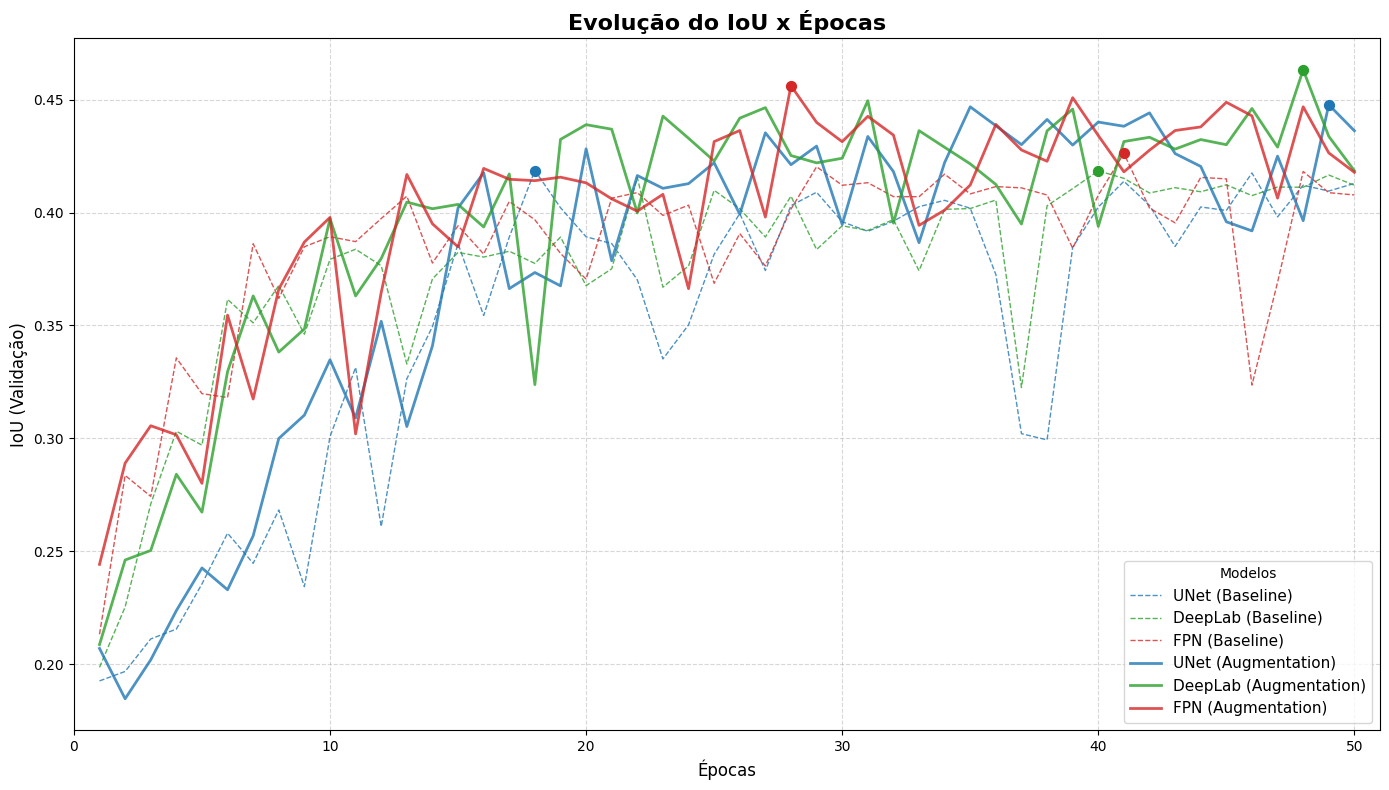

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))

colors = {
    'UNet': '#1f77b4',      # Azul
    'DeepLab': '#2ca02c',   # Verde
    'FPN': '#d62728'        # Vermelho
}

# Iterar sobre os resultados reais
for model_name, hist in results.items():
    val_iou = hist['val_iou']
    epochs_range = range(1, len(val_iou) + 1)
    
    if "UNet" in model_name:
        arch_key = 'UNet'
    elif "DeepLab" in model_name:
        arch_key = 'DeepLab'
    elif "FPN" in model_name:
        arch_key = 'FPN'
    else:
        arch_key = 'UNet'
        
    if "_com_Aug" in model_name:
        linestyle = '-' 
        linewidth = 2.0 
        label = f"{arch_key} (Augmentation)"
        marker = None
    else:
        linestyle = '--'
        linewidth = 1.0
        label = f"{arch_key} (Baseline)"
        marker = None

    # Plotar a Linha
    plt.plot(epochs_range, val_iou, 
             label=label, 
             color=colors[arch_key], 
             linestyle=linestyle, 
             linewidth=linewidth,
             alpha=0.8)

    # Insere um ponto no melhor valor ao longo da linha do gráfico
    best_epoch_idx = np.argmax(val_iou)
    best_val = val_iou[best_epoch_idx]
    plt.scatter(best_epoch_idx + 1, best_val, color=colors[arch_key], s=50, zorder=5)

plt.title("Evolução do IoU x Épocas", fontsize=16, fontweight='bold')
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("IoU (Validação)", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title="Modelos", fontsize=11, loc='lower right')
plt.xlim(0, len(val_iou) + 1)

plt.tight_layout()
plt.savefig("grafico_evolucao_iou_final.png", dpi=300)
plt.show()

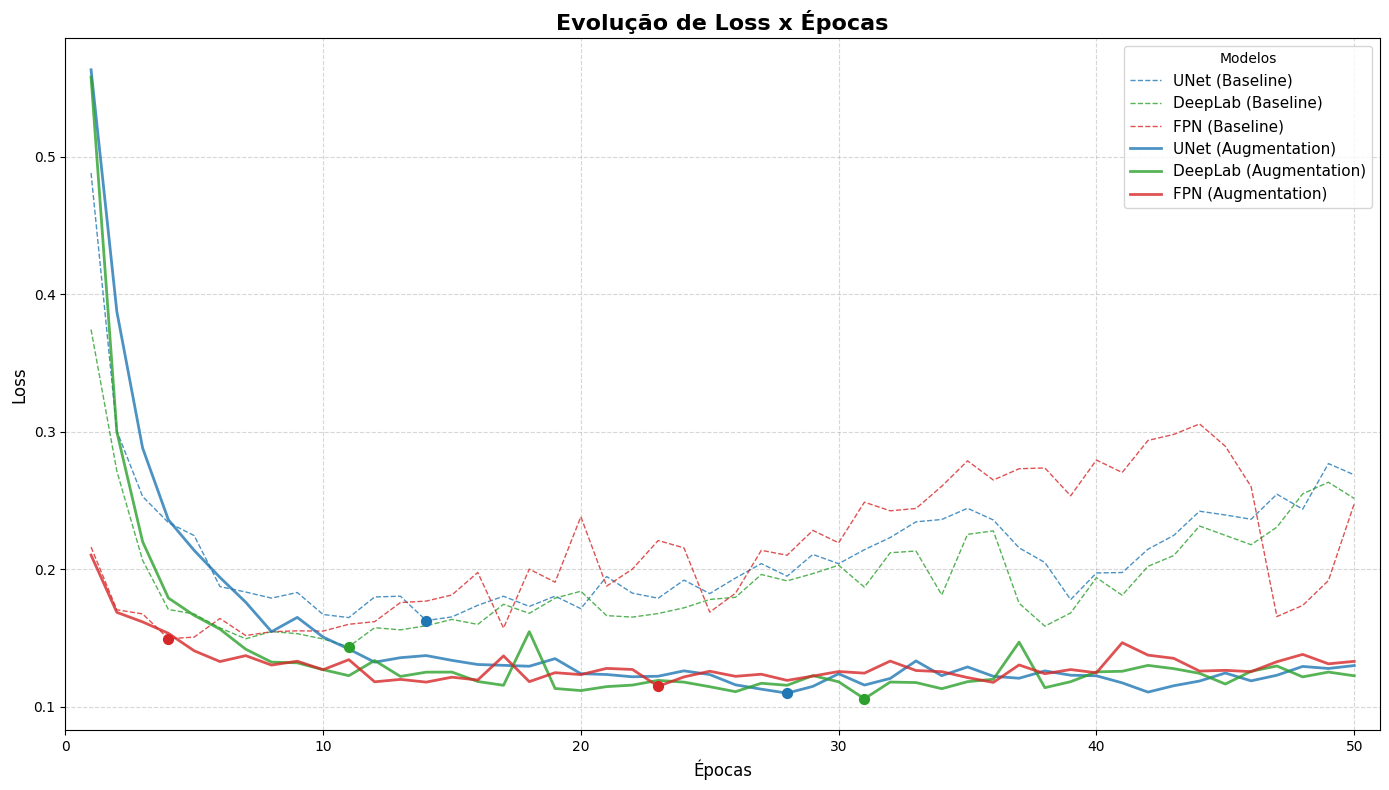

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))

colors = {
    'UNet': '#1f77b4',      # Azul
    'DeepLab': '#2ca02c',   # Verde
    'FPN': '#d62728'        # Vermelho
}

for model_name, hist in results.items():
    val_loss = hist['val_loss']
    epochs_range = range(1, len(val_loss) + 1)
    
    if "UNet" in model_name: arch_key = 'UNet'
    elif "DeepLab" in model_name: arch_key = 'DeepLab'
    elif "FPN" in model_name: arch_key = 'FPN'
    else: arch_key = 'UNet'
        
    if "_com_Aug" in model_name:
        linestyle = '-'
        linewidth = 2.0
        label = f"{arch_key} (Augmentation)"
    else:
        linestyle = '--'
        linewidth = 1.0
        label = f"{arch_key} (Baseline)"

    # Plotar loss
    plt.plot(epochs_range, val_loss, label=label, color=colors[arch_key], 
             linestyle=linestyle, linewidth=linewidth, alpha=0.8)

    # Marcar o mínimo loss (o menor ponto para o modelo)
    min_epoch_idx = np.argmin(val_loss)
    min_val = val_loss[min_epoch_idx]
    plt.scatter(min_epoch_idx + 1, min_val, color=colors[arch_key], s=50, zorder=5)

plt.title("Evolução de Loss x Épocas", fontsize=16, fontweight='bold')
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title="Modelos", fontsize=11, loc='upper right') 
plt.xlim(0, len(val_loss) + 1)

plt.tight_layout()
plt.savefig("grafico_evolucao_loss_final.png", dpi=300)
plt.show()

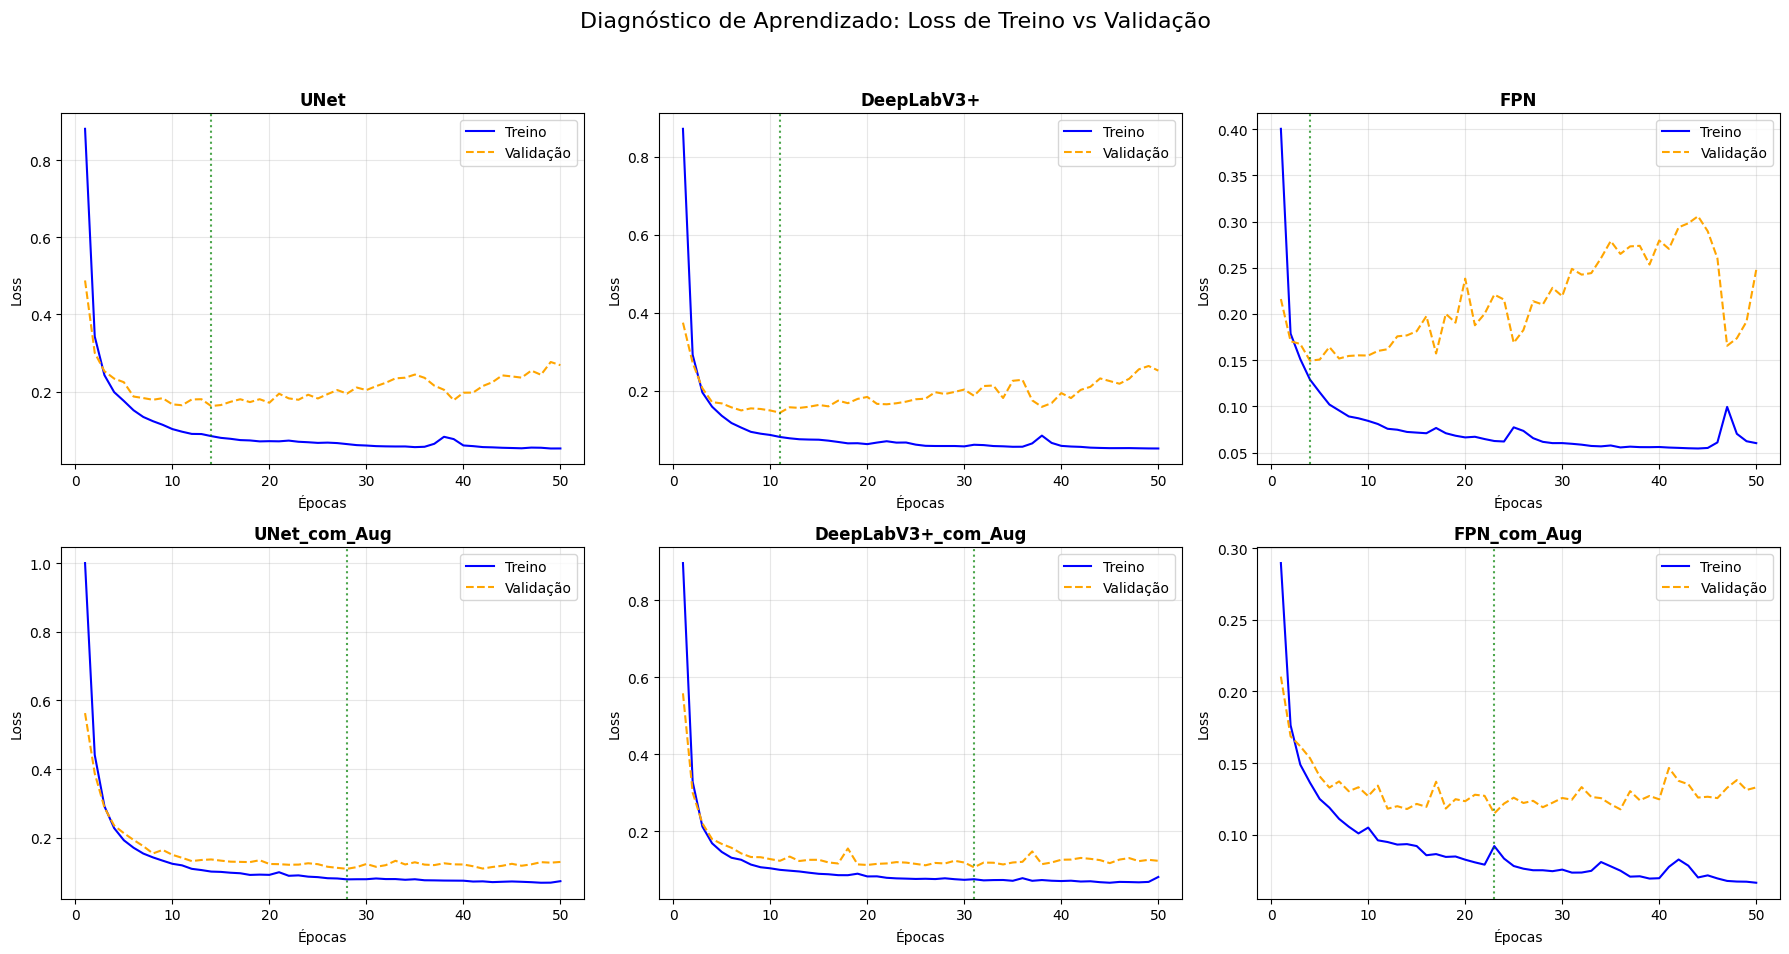

In [ ]:
# Gráfico de Loss x Épocas com curvas no conjunto de treino e validação para verificar overfitting

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Facilita o loop

# Lista dos modelos
ordered_keys = [
    'UNet', 'DeepLabV3+', 'FPN', 
    'UNet_com_Aug', 'DeepLabV3+_com_Aug', 'FPN_com_Aug'
]

plot_keys = [k for k in ordered_keys if k in results]

for i, model_name in enumerate(plot_keys):
    ax = axes[i]
    hist = results[model_name]
    
    epochs_range = range(1, len(hist['train_loss']) + 1)
    
    # Plotar Treino e Validação
    ax.plot(epochs_range, hist['train_loss'], label='Treino', color='blue', linestyle='-')
    ax.plot(epochs_range, hist['val_loss'], label='Validação', color='orange', linestyle='--')
    
    # Títulos e Estilo
    ax.set_title(f"{model_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Épocas")
    ax.set_ylabel("Loss")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Destacar o ponto mínimo de validação
    min_val_idx = np.argmin(hist['val_loss'])
    ax.axvline(x=min_val_idx+1, color='green', linestyle=':', alpha=0.7, label='Melhor Época')

plt.suptitle("Diagnóstico de Aprendizado: Loss de Treino vs Validação", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Espaçamento
plt.savefig("grafico_diagnostico_loss.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Codigo para mapear IDs para nomes das classes (sem o prefixo DATASET_)
ID_TO_NAME = {v: k.replace('DATASET_', '') for k, v in CLASS_MAP.items()}

def get_class_names_from_mask(mask_array):
    """Retorna uma string com os nomes das daninhas presentes na máscara"""
    unique_ids = np.unique(mask_array)
    names = []
    
    for uid in unique_ids:
        # Ignora Fundo (0), Ignora Original (255) e Ignora Mapeado (7)
        if uid in [0, 255, 7]: 
            continue
        if uid in ID_TO_NAME:
            names.append(ID_TO_NAME[uid])
            
    if not names:
        return "Apenas Fundo"
    return ", ".join(names)

# Função para colorir a máscara
def colorize_mask(mask):
    palette = np.array([
        [0, 0, 0],       # 0: Fundo (Preto)
        [255, 0, 0],     # 1: Caruru (Vermelho)
        [0, 255, 0],     # 2: Graminea Alto (Verde)
        [0, 0, 255],     # 3: Graminea Baixo (Azul)
        [255, 255, 0],   # 4: Mamona (Amarelo)
        [255, 0, 255],   # 5: Outras (Magenta)
        [0, 255, 255],   # 6: Trepadeira (Ciano)
        [255, 255, 255]  # 7: Ignorado (Branco)
    ])
    mask_plot = mask.copy()
    mask_plot[mask_plot == 255] = 7
    mask_plot[(mask_plot > 7) & (mask_plot != 255)] = 0
    return palette[mask_plot]

def blend_image_and_mask(image, mask_rgb, alpha=0.5):
    mask_float = mask_rgb.astype(np.float32) / 255.0
    blended = image.copy()
    is_colored = mask_float.sum(axis=2) > 0 
    blended[is_colored] = (image[is_colored] * (1 - alpha)) + (mask_float[is_colored] * alpha)
    return blended

# Função para visualizar predições
def visualize_prediction(model, dataset, index=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    if index is None:
        index = np.random.randint(0, len(dataset))
    
    print(f"Visualizando imagem índice: {index}")
    
    image_tensor, mask_true = dataset[index]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = (image_numpy * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_numpy = np.clip(image_numpy, 0, 1)

    # Detecção dos nomes presentes nas máscaras originais e preditas
    names_real = get_class_names_from_mask(mask_true.numpy())
    names_pred = get_class_names_from_mask(pred_mask)

    # Cores e sobreposição
    mask_true_rgb = colorize_mask(mask_true.numpy())
    mask_pred_rgb = colorize_mask(pred_mask)
    overlay_img = blend_image_and_mask(image_numpy, mask_pred_rgb, alpha=0.5)

    # Plota a imagem
    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    
    # 1. Original
    ax[0].imshow(image_numpy)
    ax[0].set_title("Imagem Original")
    ax[0].axis('off')
    
    # 2. Máscara Original
    ax[1].imshow(mask_true_rgb)
    ax[1].set_title(f"Máscara Original\nContém: {names_real}")
    ax[1].axis('off')
        
    # 3. Predição sobreposta na Imagem Original
    ax[2].imshow(overlay_img)
    ax[2].set_title(f"Imagem + Máscara Predita\nDetectou: {names_pred}") 
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

Visualizando imagem índice: 271


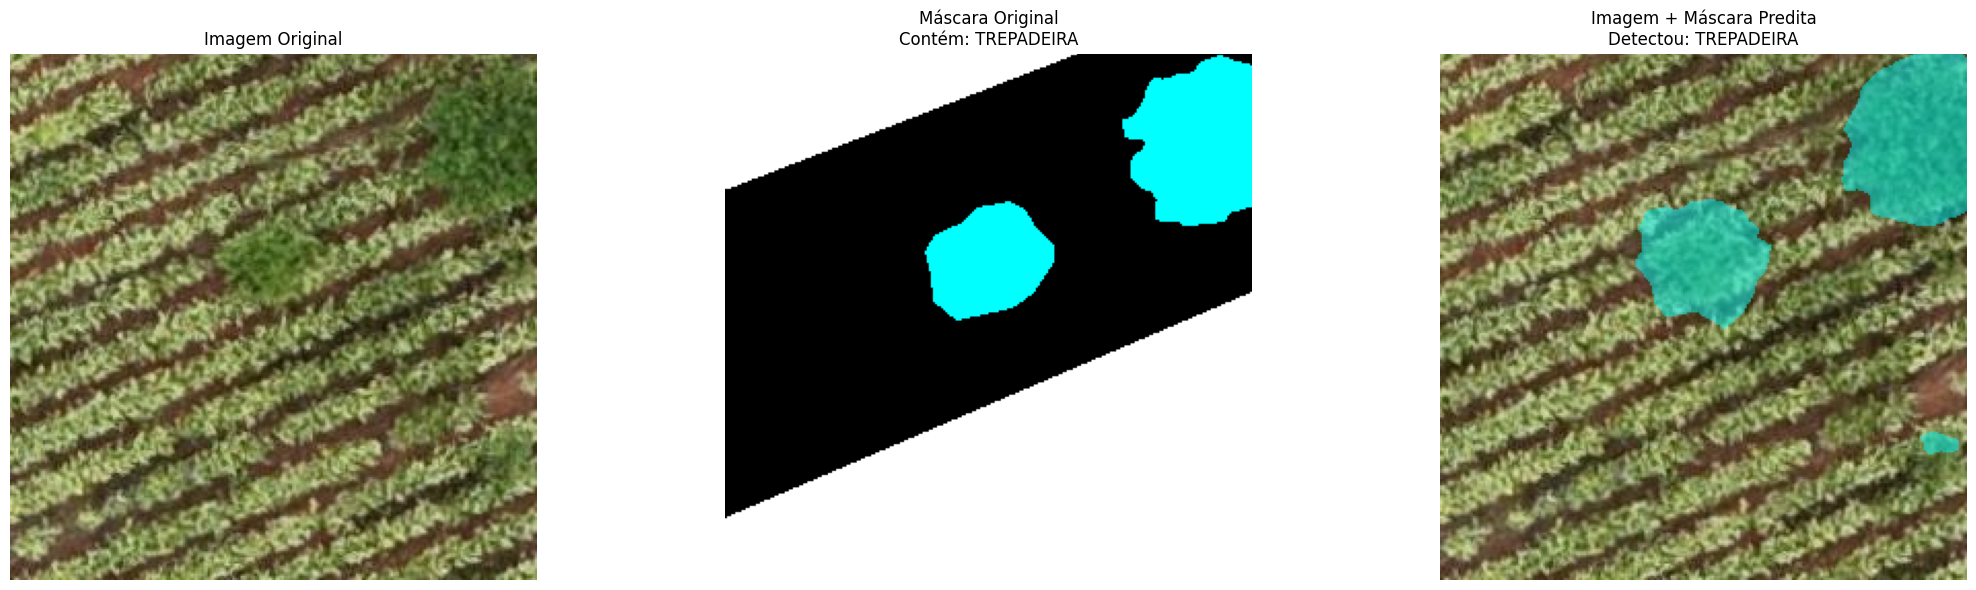

In [186]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 754


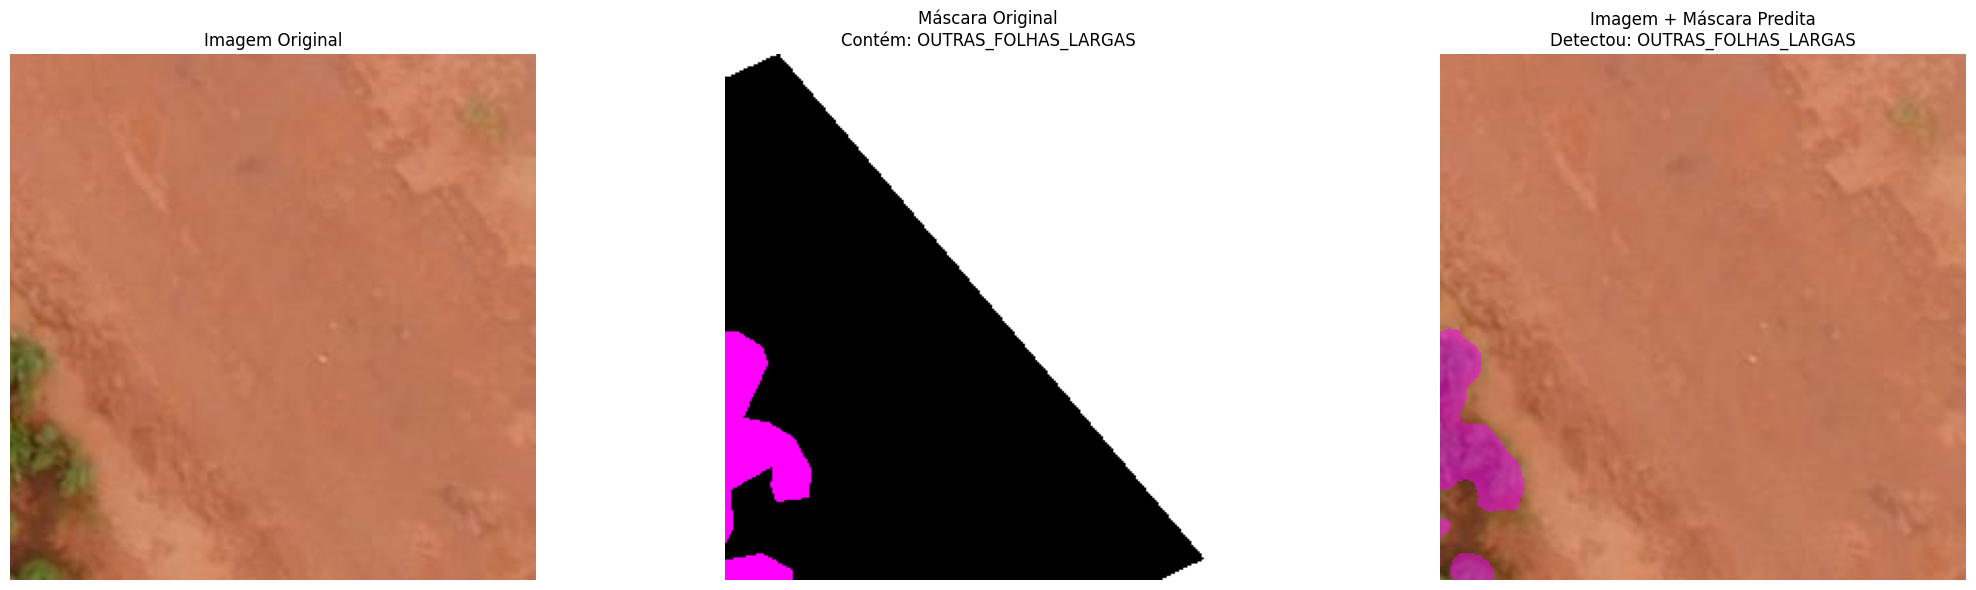

In [192]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 510


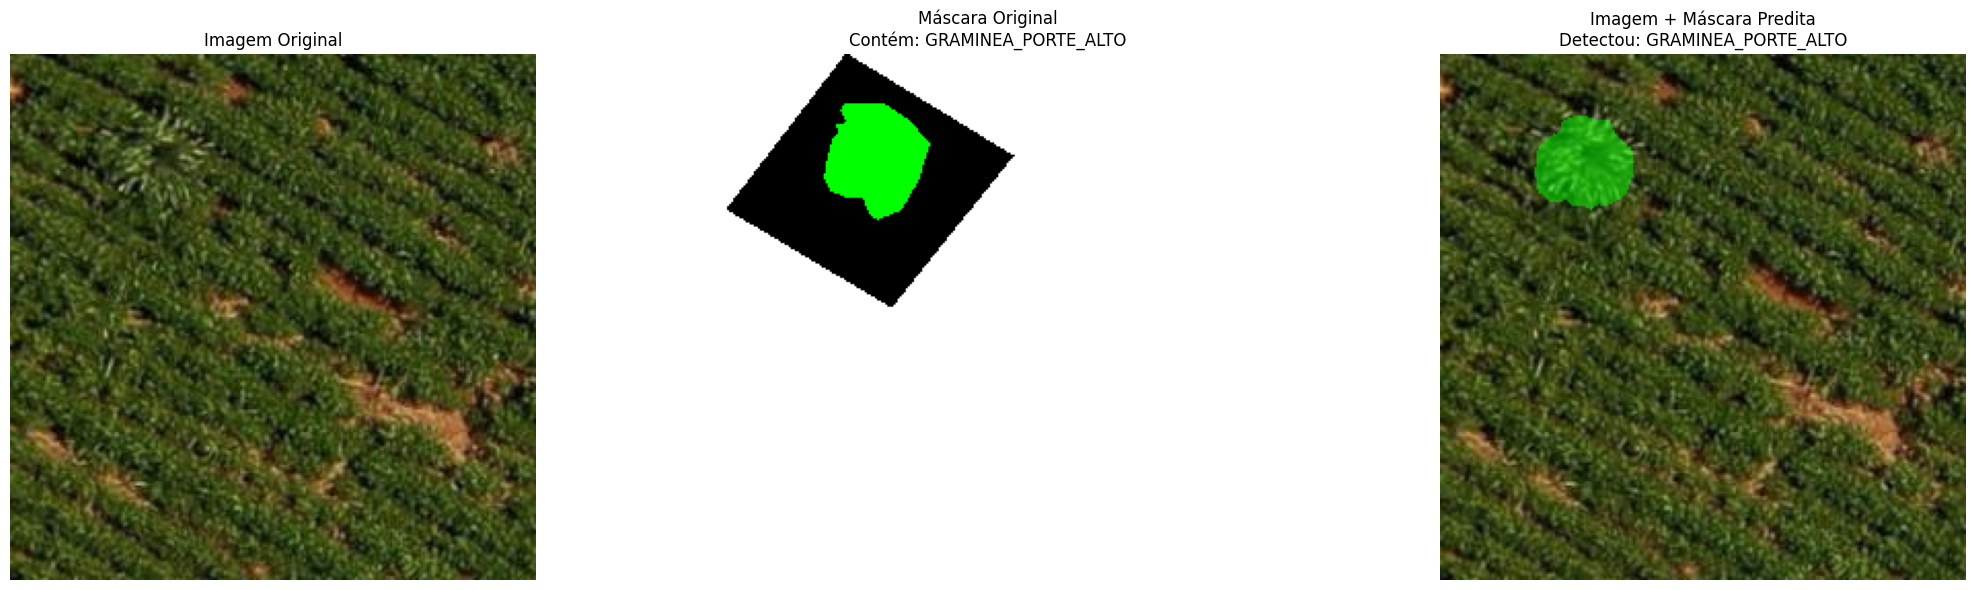

In [25]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 481


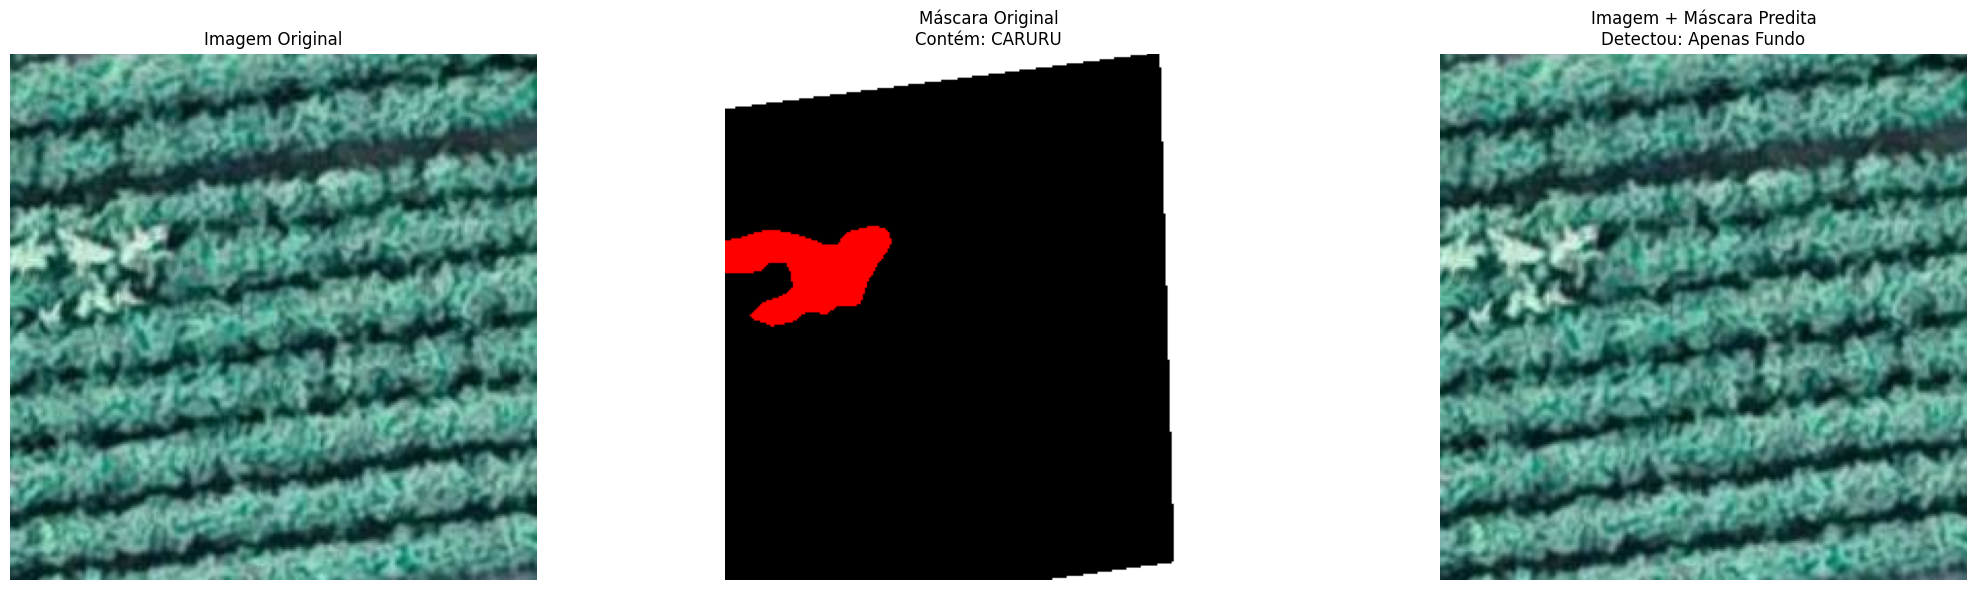

In [199]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 889


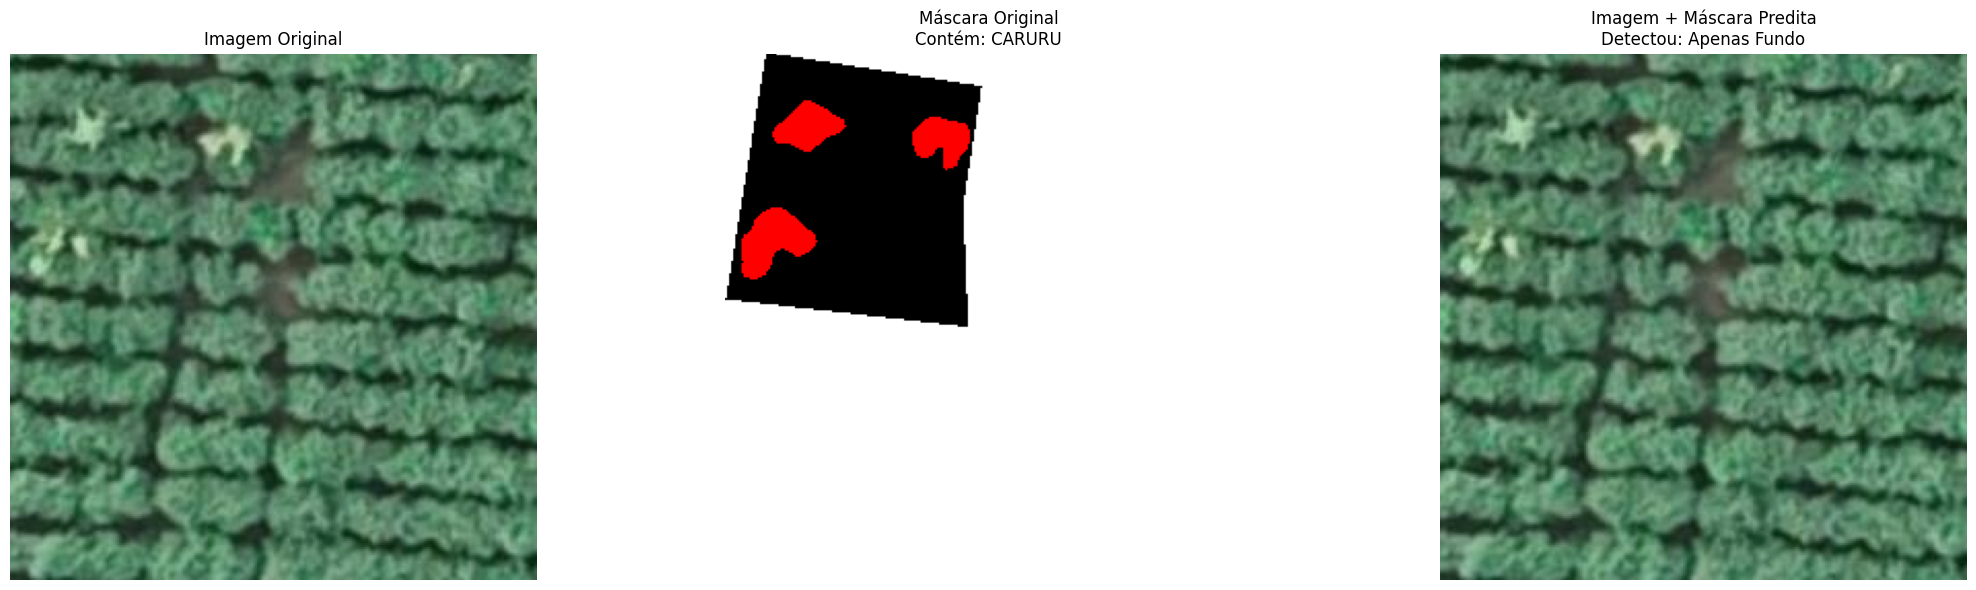

In [200]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 104


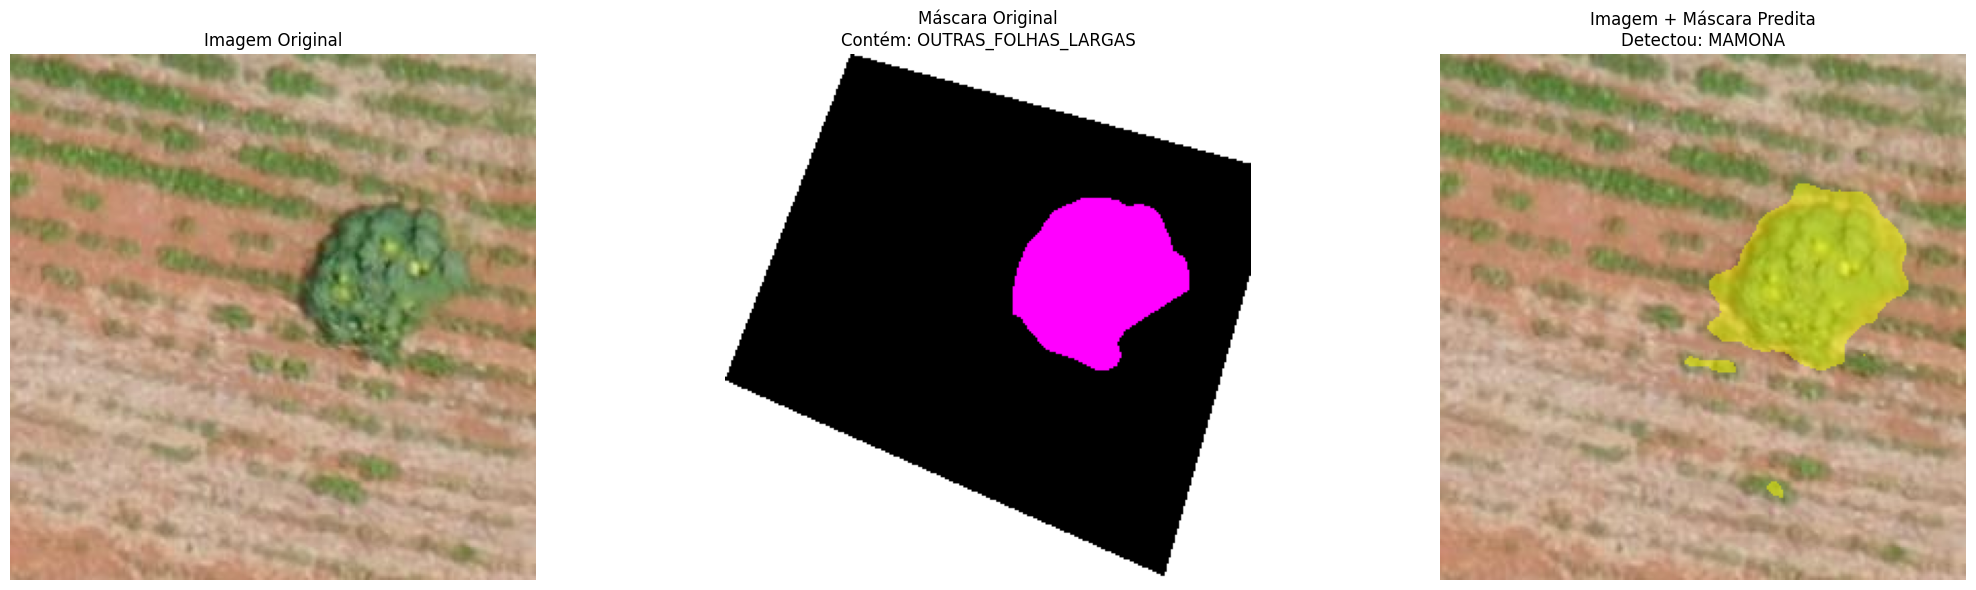

In [39]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 938


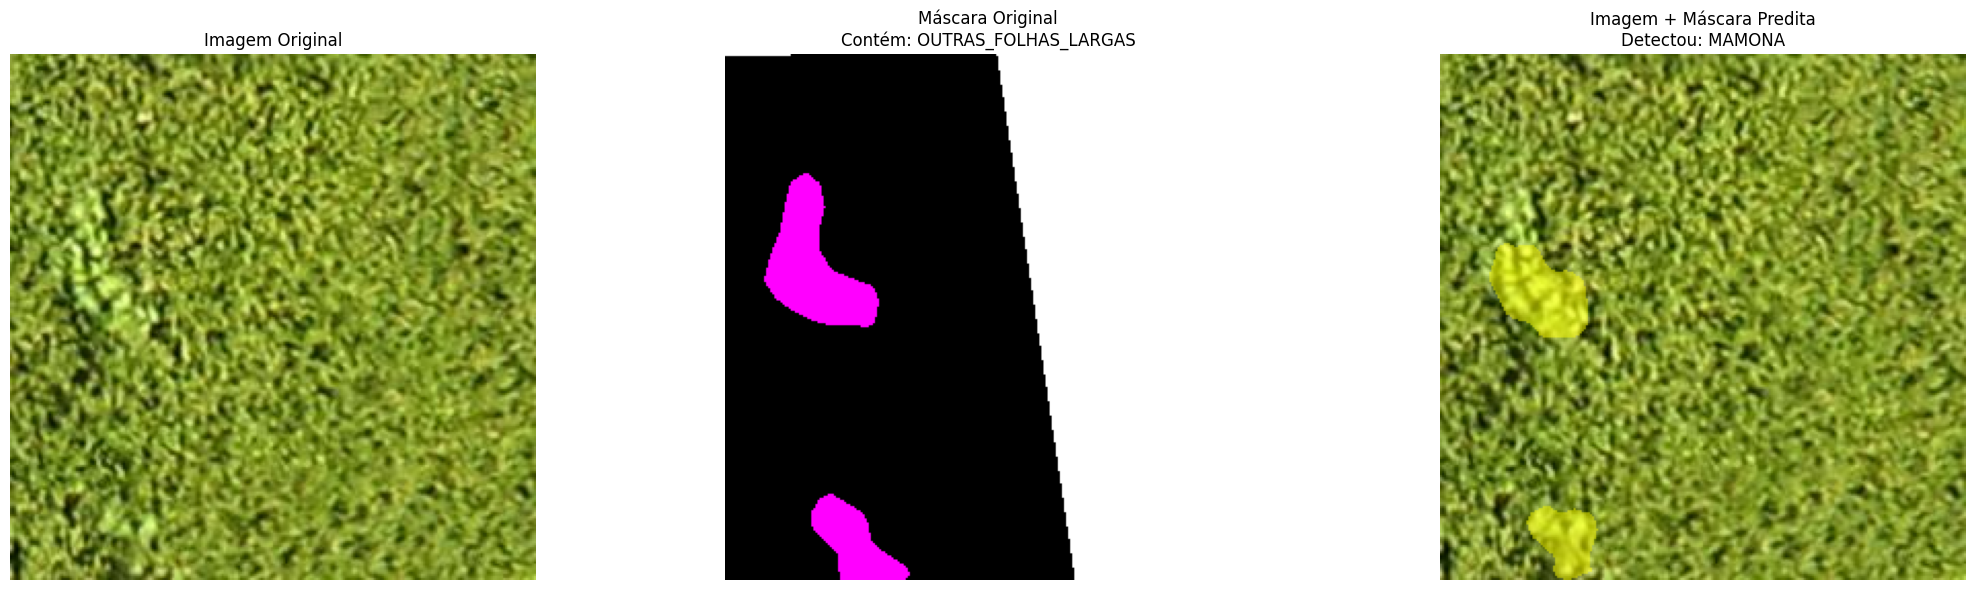

In [214]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 487


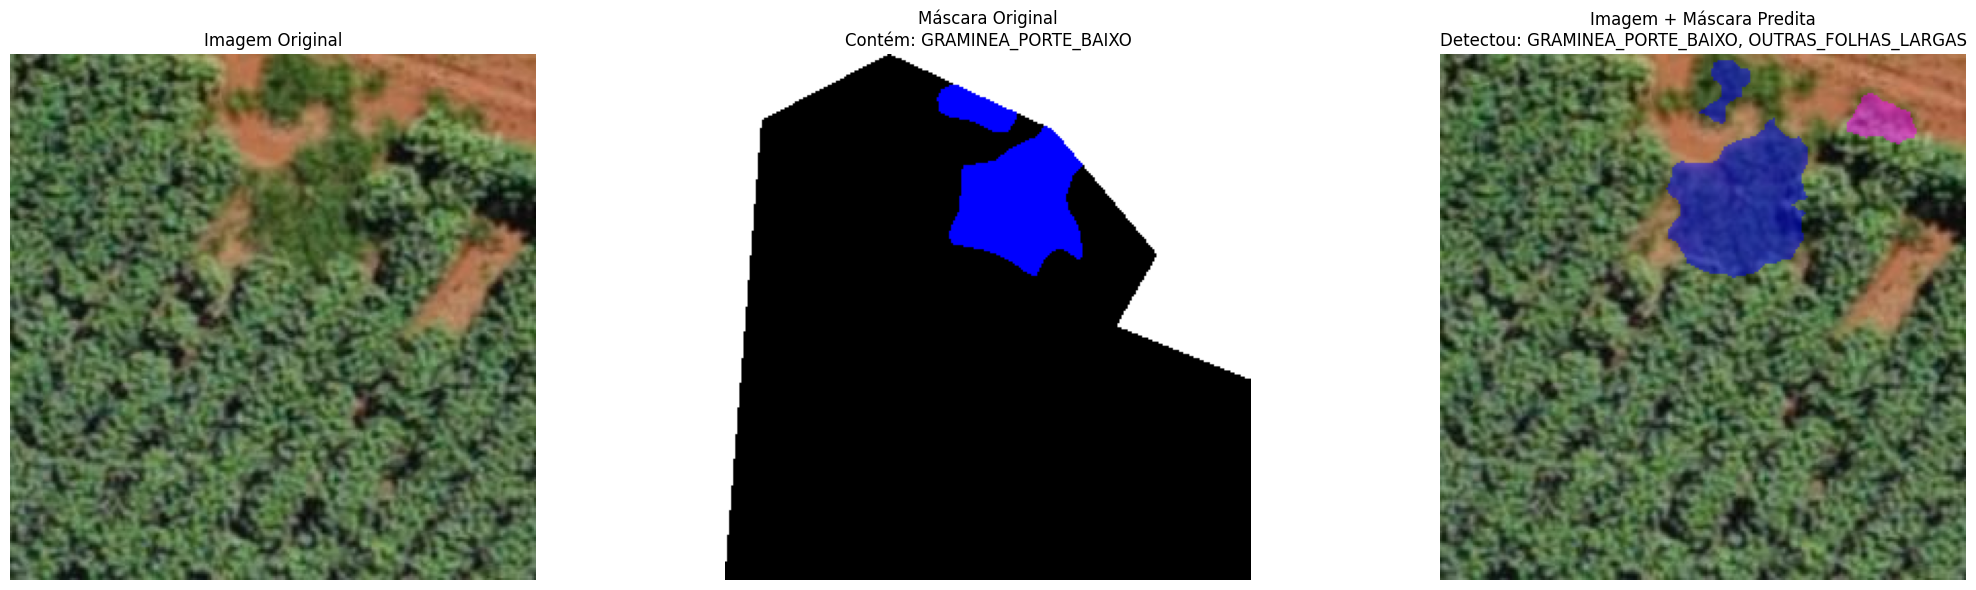

In [224]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 1075


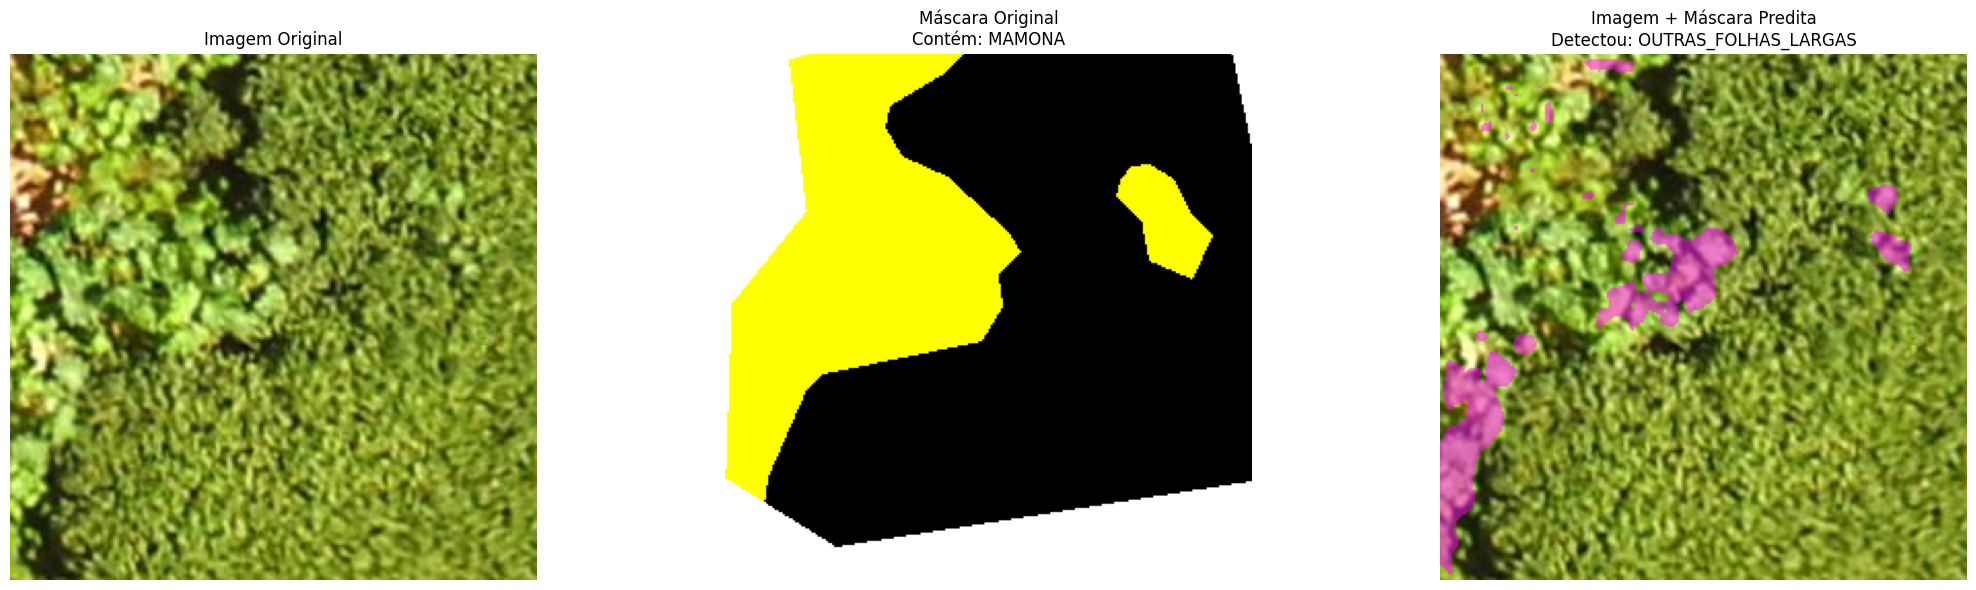

In [60]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 816


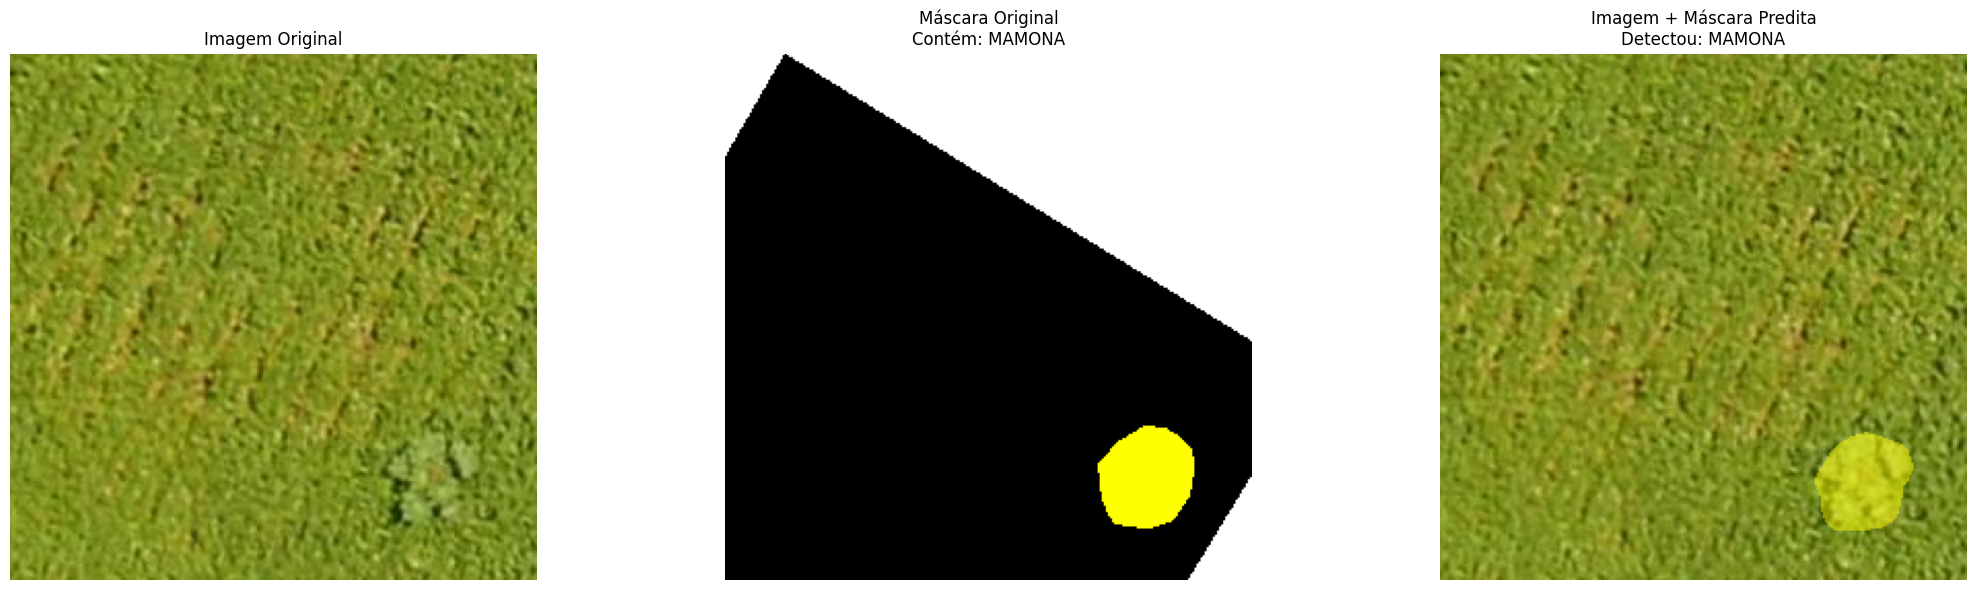

In [62]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 285


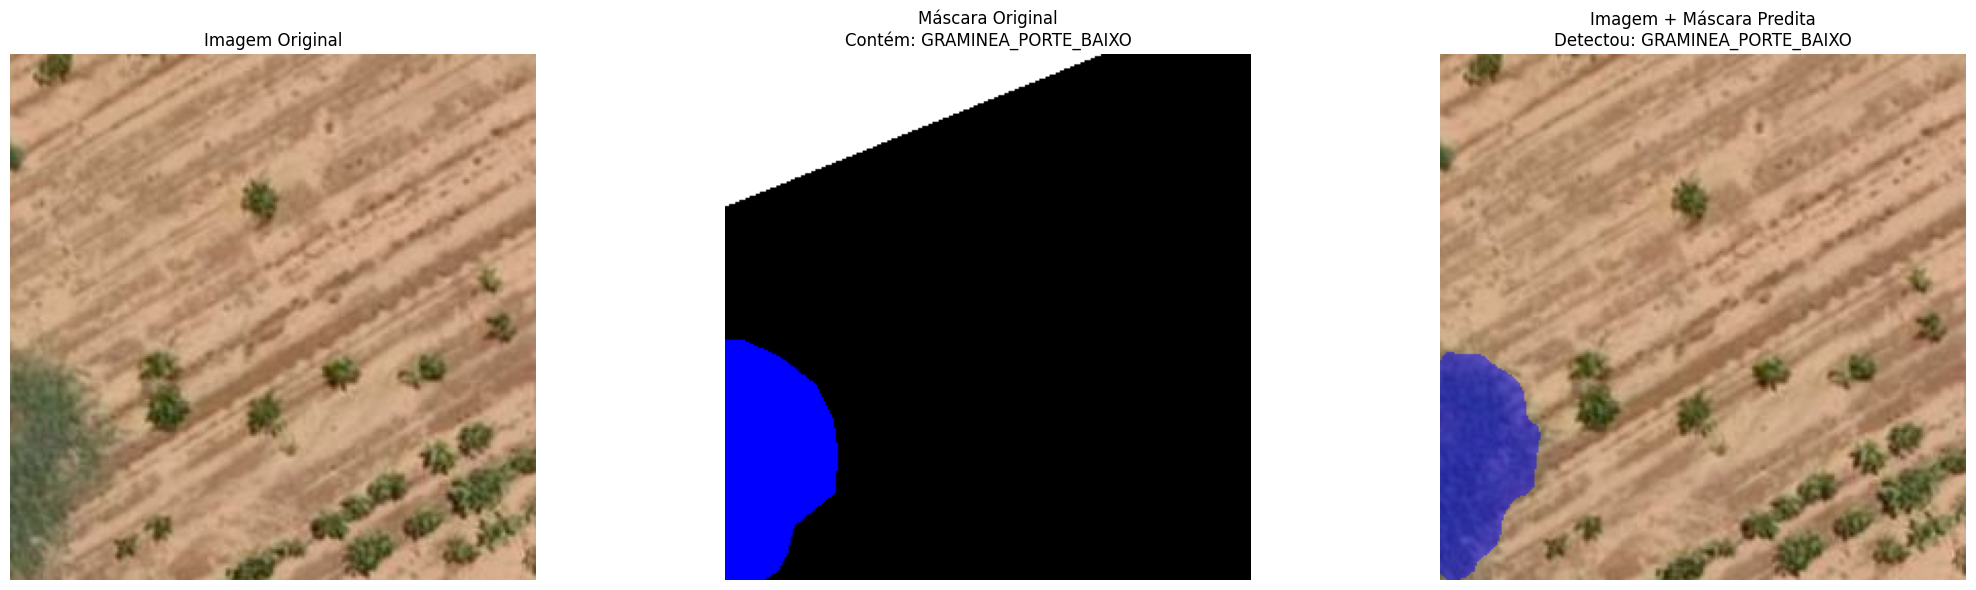

In [125]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)

Visualizando imagem índice: 412


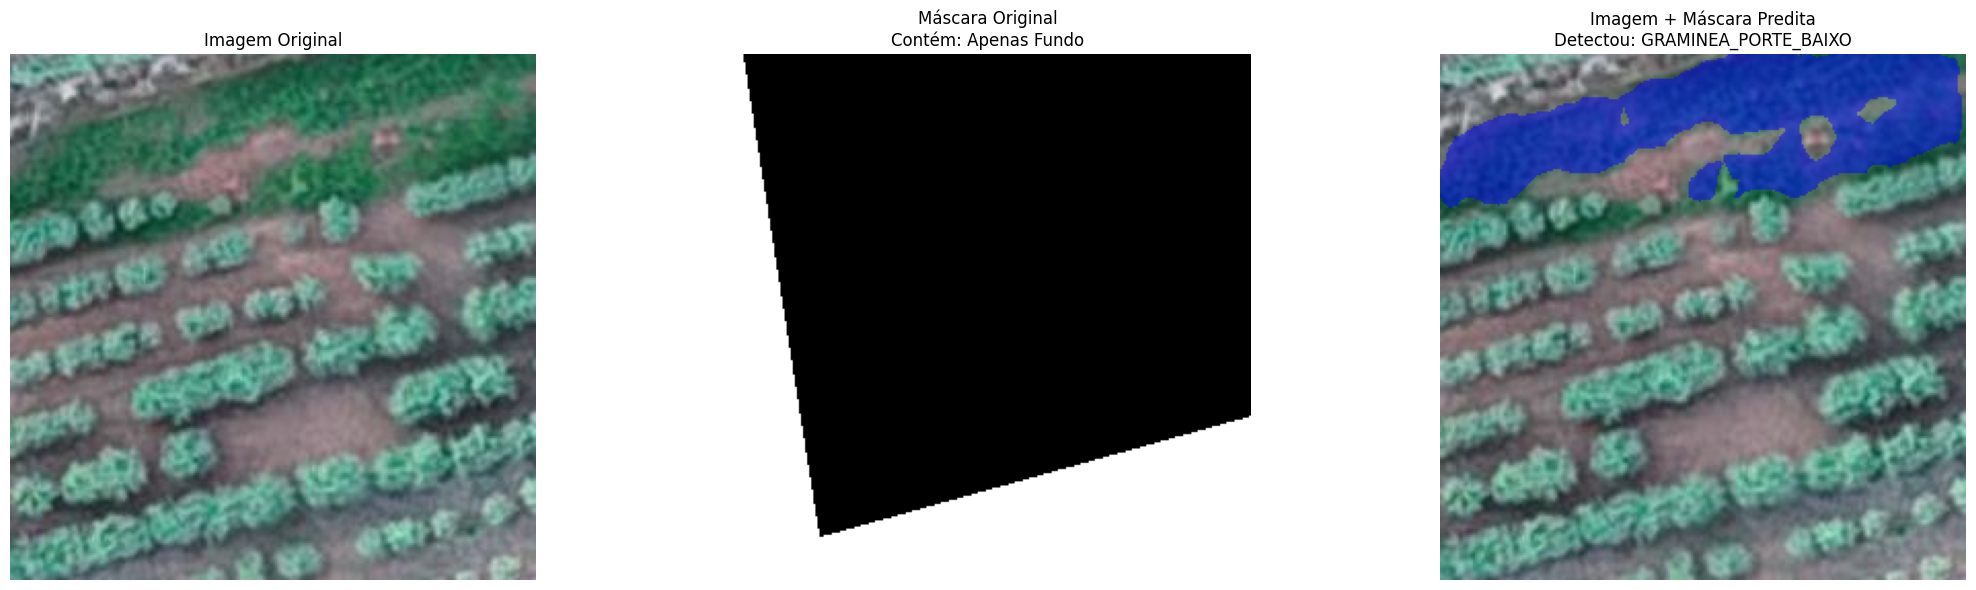

In [211]:
# Visualizar algumas previsões do melhor modelo no conjunto de teste
visualize_prediction(best_model, test_dataset)